# Проект "Определение токсичности англоязычных комментариев"

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### План работы над проектом

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделайть выводы.


### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [3]:
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
display(toxic_comments['toxic'].value_counts())
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

0    143346
1     16225
Name: toxic, dtype: int64

8.834884437596301

Классы несбалансированы. Отношение 1:8.83. Проведем поиск лучшего способа балансировки и сравним качество.

1. Изменение весов в модели обучения
2. Ресемплирование с уменьшением класса 0

Ресемплирование с увеличением класса 1 не будем использовать из-за громоздкого набора данных.

Подготовим признаки и целевой признак перед обучением. 

In [5]:
%%time

m = Mystem()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemmatize_text)

toxic_comments = toxic_comments.drop(['text'], axis=1)
del m

CPU times: user 59.5 s, sys: 11 s, total: 1min 10s
Wall time: 2min 27s


Разобьем выборку по отношению 60/20/20. Уменьшим количество кроссвалидаций до 3 из-за размера выборки.

In [6]:
target = toxic_comments['toxic']
features = toxic_comments.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12082020)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12082020)

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values.astype('U'))
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['lemm_text'].values.astype('U'))
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 3

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(95742, 126292)
(31914, 126292)
(31915, 126292)


In [7]:
%%time

classificator = LogisticRegression()
train_f1 = cross_val_score(classificator, 
                      features_train, 
                      target_train, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.6732278141449742
CPU times: user 12.5 s, sys: 11.2 s, total: 23.7 s
Wall time: 23.7 s


## 1.1 Изменение баланса классов

### 1.1.1 Изменение весов классов

In [8]:
%%time

dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7553768002693207
CPU times: user 21.7 s, sys: 19.7 s, total: 41.3 s
Wall time: 41.5 s


In [9]:
%%time

classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7553768002693207
CPU times: user 17.6 s, sys: 15.6 s, total: 33.3 s
Wall time: 33.3 s


Как видно на обучающей выборке F1-мера увеличилась. Встроенный метод повторяет значение F1.

### 1.1.2 Ресемплирование с уменьшением класса 0

Сделаем количество записей с классом 0 таким же, как и количество записей с классом 1.

In [10]:
toxic_comments_train = toxic_comments.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [11]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12082020)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = toxic_comments.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12082020)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
                                                   .values.astype('U'))
del count_tf_idf
del stopwords

In [12]:
classificator = LogisticRegression()
train_f1_downsampled = cross_val_score(classificator,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)

F1 на CV с уменьшением классов 0.8840295072766619


Прирост F1-меры ощутимый.

Построим ROC-AUC графики и просмотрим таблицу результатов баллансирования.

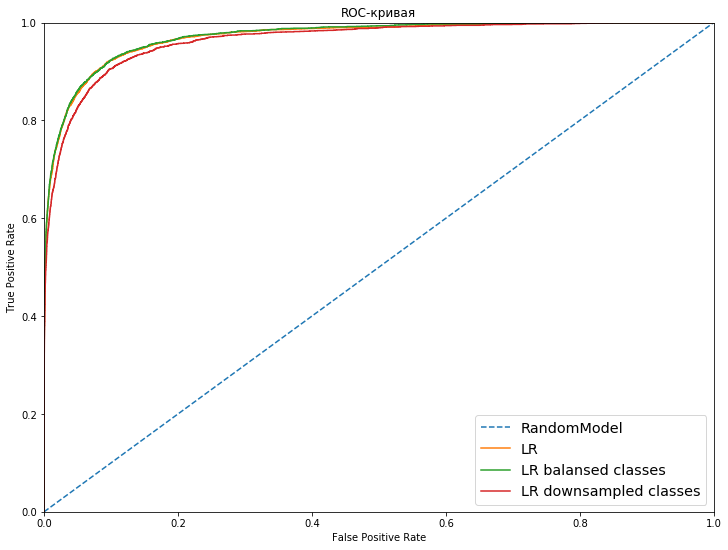

In [13]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

classificator = LogisticRegression(class_weight=dict_classes)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR balansed classes')

classificator = LogisticRegression()
classificator.fit(features_train_downsample,target_train_downsample)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR downsampled classes')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [14]:
index = ['LogisticRegression',
         'LR balansed classes',
         'LR downsampled classes']
data = {'F1 на CV':[train_f1,
                    train_f1_balanced,
                    train_f1_downsampled],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_downsampled]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LogisticRegression,0.673228,0.726889,0.970741
LR balansed classes,0.746746,0.758659,0.971826
LR downsampled classes,0.884030,0.692872,0.964168


Выберем метод балансировки по весу. Удалим ненужные переменные.

In [15]:
del toxic_comments_train
del target_train_class_zero
del target_train_class_one
del target_train_class_zero_downsample
del target_train_downsample
del features_train_downsample

### Вывод по шагу 1

В ходе преподготовки были получены признаки для обучения и разделена выборка на обучающую, валидационную и тестовую.

На тестировании оптимальными показателями F1 и AUC-ROC обладает классификатор, где учтен вес классов. В обучении мы будем использовать именно этот метод балансирования.

# 2. Обучение

Для обучения выберем следующие модели:

1. LogisticRegression
2. DecisionTreeClassifier
3. CatBoostClassifier
4. SGDClassifier

## 2.1 Классификатор LogisticRegression

In [16]:
%%time

classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}

Grid scores on development set:

0.713043 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.713043 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.712851 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.755413 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.755376 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.755377 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.763108 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.763119 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.763068 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': '

In [17]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7631191168916892
F1 на валидации 0.7647146475935032
CPU times: user 25.2 s, sys: 26.4 s, total: 51.6 s
Wall time: 51.9 s


## 2.2 Классификатор DecisionTreeClassifier

In [18]:
%%time

classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[12082020],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 40, 'random_state': 12082020}

Grid scores on development set:

0.602556 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 30, 'random_state': 12082020}
0.609787 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 32, 'random_state': 12082020}
0.617002 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 34, 'random_state': 12082020}
0.613539 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 36, 'random_state': 12082020}
0.618676 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 38, 'random_state': 12082020}
0.625155 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 40, 'random_state': 12082020}
0.619878 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 42, 'random_state': 12082020}
0.608491 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_dep

In [19]:
%%time

classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6251551031277168
F1 на валидации 0.605458320973005
CPU times: user 34 s, sys: 0 ns, total: 34 s
Wall time: 34.8 s


## 2.3 Классификатор CatBoostClassifier

In [20]:
%%time

classificator = CatBoostClassifier(verbose=False, iterations=200)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train, 
                                         target_train, 
                                         cv=cv_counts, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.7186686644372537
F1 на валидации 0.7413539367181752
CPU times: user 48min 38s, sys: 8min 29s, total: 57min 7s
Wall time: 57min 30s


## 2.4 Классификатор SGDClassifier

In [21]:
%%time

classificator = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[12082020],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.2, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12082020}

Grid scores on development set:

0.736420 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 12082020}
0.718251 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 12082020}
0.751749 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 12082020}
0.739705 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 12082020}
0.717909 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 12082020}
0.756

In [22]:
%%time

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_SGDC)
print('F1 на валидации', valid_f1_SGDC)

F1 на cv 0.760833316568524
F1 на валидации 0.7602816901408451
CPU times: user 1.92 s, sys: 85.9 ms, total: 2.01 s
Wall time: 2.02 s


Выведем таблицу валидации лучших моделей.

In [23]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier',
         'SGDClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC,
                    cv_f1_SGDC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC,
                           valid_f1_SGDC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.763119,0.764715,True
DecisionTreeClassifier,0.625155,0.605458,False
CatBoostClassifier,0.718669,0.741354,False
SGDClassifier,0.760833,0.760282,True


### Вывод по шагу 2

К тестовому набору данных перейдут LogisticRegression и SGDClassifier.

# 3. Выводы

Проведем получение F1-меры, precision, recall, accuracy и roc_auc. Так же построим графики.

Метрики LogisticRegression
ROC AUC: 0.9634591597615798
F1: 0.7650257163850109
Precision: 0.738230289279637
Recall: 0.7938395852394022
Accuracy: 0.94989816700611

Метрики SGDClassifier
ROC AUC: 0.9678761170538359
F1: 0.7566144895414878
Precision: 0.6931472081218274
Recall: 0.8328758767917048
Accuracy: 0.9449475168416105



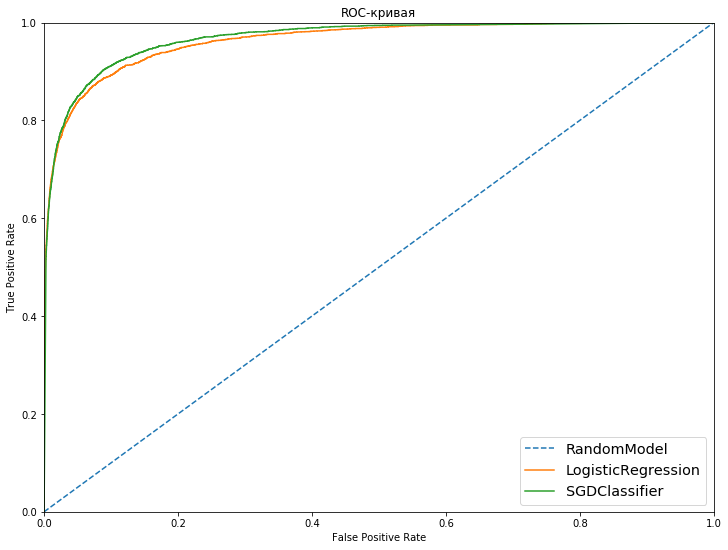

In [24]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='SGDClassifier')
print('Метрики SGDClassifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

### Итоговый вывод

В ходе работы над проектом было сделано:

- Подготовленны данные обучения на моделях.
- Выбран способ баланса классов и поделены данные на обучающую, валидационную и тестовою выборку.
- Обучены модели и выбраны лучшие из них на валидационной выборке.
- Показаны параметры качества моделей.

Исходные данные обладают большим количеством признаков. Созданных столбцов больше, чем записей данных. Так как TF-IDF превращают текст в численные значения, лучшими моделями стали LogisticRegression и SGDClassifier. CatBoostClassifier может показать себя очень хорошо при долгом обучении на данных. В ходе тестов данный классификатор мог обучатся до 5 часов.

На тестовой выбоке по метрике F1 лучше всего себя показал LogisticRegression всего на 0.09.
Данная модель обладает больними показателями Precision и Accuracy. Это говорит нам, что токсичные комментарии находятся лучше.

SGDClassifier показал себя лучше в ROC AUC и Recall метриках. Модель способна обработать больше записей. 